In [2]:
!pip install moviepy
!pip install librosa
!pip install scipy
!pip install matplotlib

  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 11.3 MB/s eta 0:00:0031m11.8 MB/s eta 0:00:01
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


In [13]:
import numpy as np
import librosa
from moviepy.editor import VideoFileClip, concatenate_videoclips
import scipy 

def prepare_audio_files(video_files, gate_threshold_db=-25):
    """
    extracts the audio tracks from the video files
    applies a noise gate at the sent threshold
    """
    return

def read_wav_file(file_path):
    audio_data, _ = librosa.load(file_path, sr=48000, mono=True)
    return audio_data


def moving_average(arr1, frame_length):
    """
    Computes a moving average using the sent frame length
    """
    if frame_length <= 0 or frame_length > len(arr1):
        raise ValueError("Frame length must be a positive integer less than or equal to the length of input arrays")
    
    # result = np.convolve(arr1, np.ones(int(frame_length))/frame_length, mode='valid')    
    result = scipy.signal.convolve(arr1, np.ones(int(frame_length))/frame_length, mode='valid')    
    
    zeroes = len(arr1) - len(result)
    print("zero pad", zeroes)
    result = np.concatenate((np.zeros(zeroes), result))
    return result

def test_moving_average():
    # Example usage:
    arr1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    result = moving_average(arr1, 3)
    print("Moving Average of arr1:", result)


def find_highest_elements(arr1, arr2):
    """
    returns an array of the same length as arr1 and arr2
    for each step in the new array, if arr1[step] > arr2[step], write 0, otherwise, 1
    """
    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length")
    
    result = []
    for i in range(len(arr1)):
        if arr1[i] > arr2[i]:
            result.append(0)
        elif arr2[i] > arr1[i]:
            result.append(1)
        else:
            result.append(0)  # You can modify this to handle equal values differently if needed
    
    return np.array(result)

def process_repeats(input, thresh = 100):
    """
    work through values in input, writing current value 
    to an output
    once you've seen any value > thresh times, 
    switch to that value as your output value 
    and reset counts so the race to take over starts again
    """
    vals = np.unique(input)
    counts = {}
    for v in vals: counts[v] = 0 
    current = vals[0]
    output = np.zeros(len(input))
    for i in range(len(input)):# iterate input
        counts[input[i]] += 1 # log count for input at step i
        for k in counts.keys(): # look for count > thresh
            if counts[k] > thresh: # value k is over thresh
                current = k
                # reset counters
                for k in counts.keys(): counts[k] = 0
        output[i] = current
    return output




def test_find_highest_elements():
    # Example usage:
    arr1 = np.array([1, 2, 3, 4, 5])
    arr2 = np.array([5, 4, 3, 2, 1])
    
    result = find_highest_elements(arr1, arr2)
    print("Comparison Result:", result)



def count_repeats(arr):
    """
    used to create the segment descriptors: [[0, 123], [1, 2323]]
    where the first value is the array value, the second is the number of repeats
    iterates over the sent 1D array, counting the length of repeating sequences
    when the value changes, counter is set to zero
    outputs a list of values encountered and how many repeats of each it sees
    """
    lens = []
    count = 0
    val = arr[0]
    for x in arr:
        if x == val: # no change
            count += 1
        else: # change
            lens.append([val, count])
            val = x
            count = 0
    return lens
    
def create_video_edit_moviepy(video_paths, segment_descriptors):
    clips = []
    offset = 0  # Initialize the offset
    videos = [VideoFileClip(p) for p in video_paths]
    #for video_index, duration in segment_descriptors:
    for seg_pair in segment_descriptors:
        video_index = int(seg_pair[0])
        duration = seg_pair[1]
        # video_path = video_paths[video_index]
        # clip = VideoFileClip(video_path).subclip(offset, offset + duration)
        clip = videos[video_index].subclip(offset, offset + duration)
        clips.append(clip)
        offset += duration  # Accumulate the offset for the next segment

    final_clip = concatenate_videoclips(clips)
    # final_clip.write_videofile(output_path, codec='libx264')
    
    print(f'Video edit created')
    return final_clip


	

## analysis example

In [20]:
## compute moving average
print("Reading files")
sr = 48000
clip1 = read_wav_file('../data/mark-aligned.wav')
clip2 = read_wav_file('../data/matthew-aligned.wav')
frame_size = 128
print("Computing moving average for", (len(clip1) / sr), "seconds")
clip1 = moving_average(clip1, frame_size)
clip2 = moving_average(clip2, frame_size)
print("Selecting loudest clip for", (len(clip1) / sr), "seconds")
## find the highest-> [0, 0, 1, 1, ...] per audio sample
highest_inds = find_highest_elements(clip1, clip2)
## apply repeater filer
highest_inds = process_repeats(highest_inds, thresh=48000)
## verify there are some switches happening 
assert len(np.unique(highest_inds)) > 1, "Problem with highest inds - only one highest ind: " + str(np.unique(highest_inds))
print("Counting repeat lengths for", (len(highest_inds) / sr), "seconds")
## count repeats
item_reps_all = count_repeats(highest_inds)
print("Reps add up to ", (np.sum([v[1] for v in item_reps_all]) / sr), "seconds")
print("Filtering short repeats")
## apply repeat limits 
#item_reps_filt = filter_to_long_repeats(item_reps_all, 48000/4)
#print("Filtered reps add up to ", (np.sum([v[1] for v in item_reps_filt]) / sr), "seconds")

print(item_reps_all)

Reading files
Computing moving average for 99.5 seconds
zero pad 127
zero pad 127
Selecting loudest clip for 99.5 seconds
Counting repeat lengths for 99.5 seconds
Reps add up to  98.36072916666667 seconds
Filtering short repeats
[[0.0, 187023], [1.0, 95785], [0.0, 95718], [1.0, 92867], [0.0, 183246], [1.0, 85266], [0.0, 95074], [1.0, 87704], [0.0, 2965053], [1.0, 89646], [0.0, 187253], [1.0, 95373], [0.0, 272009], [1.0, 94689], [0.0, 94609]]


## Do the video editing

In [21]:
# Example usage:
video_paths = ['../data/mark-aligned.mov', '../data/matthew-aligned.mov']
# convert to fractions of a second
item_reps_secs = [[v[0], v[1]/48000] for v in item_reps_all]
clip = create_video_edit_moviepy(video_paths, item_reps_secs)
item_reps_secs

Video edit created


[[0.0, 3.8963125],
 [1.0, 1.9955208333333334],
 [0.0, 1.994125],
 [1.0, 1.9347291666666666],
 [0.0, 3.817625],
 [1.0, 1.776375],
 [0.0, 1.9807083333333333],
 [1.0, 1.8271666666666666],
 [0.0, 61.7719375],
 [1.0, 1.867625],
 [0.0, 3.901104166666667],
 [1.0, 1.9869375],
 [0.0, 5.666854166666667],
 [1.0, 1.9726875],
 [0.0, 1.9710208333333334]]

In [22]:
#clip.write_videofile('test2.mov', codec='prores', audio_codec='pcm_s32le')
clip.write_videofile('mm-test-full-sec.mp4')

Moviepy - Building video mm-test-full-sec.mp4.
MoviePy - Writing audio in mm-test-full-secTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video mm-test-full-sec.mp4



Moviepy - Done !
Moviepy - video ready mm-test-full-sec.mp4


In [ ]:
?clip.write_videofile

8635201 8640000 8640000 8635201
(8635201,) (8640000,)


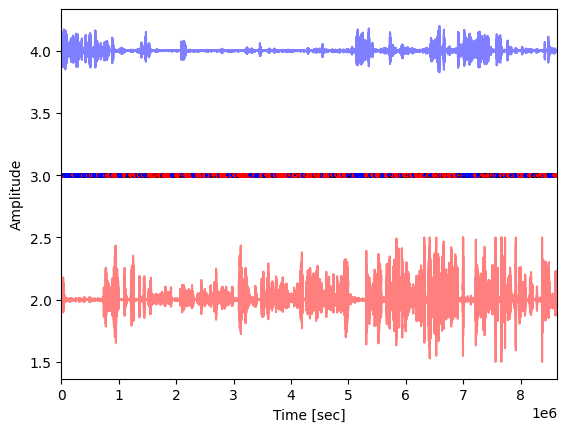

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa

def read_wav_file(file_path):
    audio_data, _ = librosa.load(file_path, sr=48000, mono=True)
    return audio_data


sr = 48000
# Load wav files
# matthew_audio = read_wav_file('../data/matthew-aligned.wav')  
# mark_audio = read_wav_file('../data/mark-aligned.wav')
matthew_audio = read_wav_file('../data/clip3.wav')  
mark_audio = read_wav_file('../data/clip4.wav')

if len(matthew_audio) > len(mark_audio):
    matthew_audio = matthew_audio[0:len(mark_audio)]
else:
    mark_audio = mark_audio[0:len(matthew_audio)]
    

# Ensure same sampling frequency

# Calculate moving average loudness over 0.1 sec window 
window_size = round(0.1 * sr)  
matthew_loudness = np.convolve(np.abs(matthew_audio), np.ones(window_size)/window_size, mode='valid')
mark_loudness = np.convolve(np.abs(mark_audio), np.ones(window_size)/window_size, mode='valid')

# Generate overlay colors
colors = ['blue' if l1 > l2 else 'red' for l1, l2 in zip(matthew_loudness, mark_loudness)]
# Plot waveforms and overlay
# time = np.arange(len(colors)) / sr
time = np.arange(len(colors))

print(len(colors), len(matthew_audio), len(mark_audio), len(time))
print(time.shape, matthew_audio.shape)
plt.plot(time, matthew_audio[0:len(time)] + 4, alpha=0.5, color='blue')
plt.plot(time, mark_audio[0:len(time)] + 2, alpha=0.5, color='red')  
plt.scatter(time, np.zeros_like(time)+3, c=colors, s=3)
plt.xlim([time[0], time[-1]])
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()